In [1]:
import os
import numpy as np
from keras.applications import ResNet50V2
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu

* data shape이 299 * 299이므로 따로 전처리가 필요 없는 ResNet50V2를 사용함. 


* include_top 을 False 함으로써 기존 ResNet50V2의 classfier을 삭제함

In [2]:
conv_base = ResNet50V2(weights = 'imagenet',
                 include_top = False,
                 input_shape = (299, 299, 3))

In [3]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [4]:
base_dir = r'D:\dataset\dental\data'

data = np.load(base_dir + "\\data_ff.npy")
label = np.load(base_dir + "\\labels_angle_class_face.npy")

(287, 299, 299, 3)


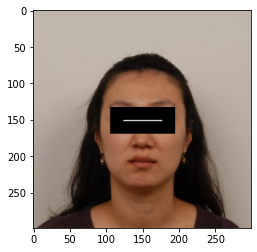

In [5]:
plt.imshow(data[1])
print(data.shape)

* model2 = conv_base 전체를 동결시킨 뒤 새로운 classifier를 붙혀 학습하고, base의 동결을 일부 풀고 다시 학습시킨다.
      = batch_size = 40, epochs = 150으로 둠


* 파라미터 수는 층의 수와 각 층의 유닛 수에 의해 결정된다.
    * 메모리 사용량은 파라미터 수에 따라 결정됨.
    * 파라미터(지능으로 비유)가 데이터에 비해 작으면 모델이 학습을 잘 못하고, 많으면 over fitting이 빨리 일어난다.

* softmax함수
    * 유닛의 출력값에 대하여 마지막 단계에서 출력값에 대한 정규화 해주는 함수
    * 합은 언제나 1.0 이다

In [6]:
#메모리 사용량은 batch size와 모델의 복잡성
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten(input_shape=(10,10,2048)))
model2.add(layers.Dense(128, activation='relu', input_dim=(10*10*2048)))
model2.add(layers.Dense(3, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 10, 10, 2048)      23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               26214528  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 49,779,715
Trainable params: 49,734,275
Non-trainable params: 45,440
_________________________________________________________________


In [7]:
len(model2.trainable_weights)

176

In [8]:
#conv_base동결
conv_base.trainable = False
len(model2.trainable_weights)

4

In [9]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 10, 10, 2048)      23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               26214528  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 49,779,715
Trainable params: 26,214,915
Non-trainable params: 23,564,800
_________________________________________________________________


* data와 label을 scikit-learn으로 나누기
* 일반적으로 train : validation : test = 6 : 2 : 2 로 나눈다

In [10]:
train_data2, test_data2, train_label2, test_label2= train_test_split(data, label, test_size = 0.2, random_state = 123)
train_data2, val_data2, train_label2, val_label2 = train_test_split(train_data2, train_label2, test_size = 0.2, random_state = 123)

In [11]:
#원 핫 인코딩을 위해 label을 바꿈
one_hot_train_labels = to_categorical(train_label2 - 1)
one_hot_validation_labels = to_categorical(val_label2 - 1)
one_hot_test_labels = to_categorical(test_label2 - 1)

* rmsprop 보다 더 좋은 성능을 Adam이 낸다
* activation을 softmax를 사용했기 때문에, 또한 다중 분류에서 'catagorical_crossentropy'가 가장 성능이 좋기 때문에 loss로 'catagorical_crossentropy'를 사용함.
   * 'catagorical_crossentropy' = 두 확률분포(네트워크가 출력한 확률분포 & 진짜 label의 분포) 사이의 거리를 측정함

In [12]:
model2.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

* batch_size를 너무 작게 잡는다면 data set에 있는 오류에 대해 민감하게 weight가 업데이트 될 수 있음

In [13]:
# Train model
history = model2.fit(train_data2, one_hot_train_labels,
                    epochs=150,
                    batch_size=40, 
                    validation_data=(val_data2, one_hot_validation_labels))


Train on 183 samples, validate on 46 samples
Epoch 1/150
183/183 [==============================] - 10s 53ms/step - loss: 50.9065 - acc: 0.3497 - val_loss: 440.4006 - val_acc: 0.3913
Epoch 2/150
183/183 [==============================] - 3s 14ms/step - loss: 3.1346 - acc: 0.6175 - val_loss: 82.2144 - val_acc: 0.3261
Epoch 3/150
183/183 [==============================] - 3s 14ms/step - loss: 1.1772 - acc: 0.6011 - val_loss: 37.2483 - val_acc: 0.2826
Epoch 4/150
183/183 [==============================] - 3s 14ms/step - loss: 0.5559 - acc: 0.6776 - val_loss: 1.8985 - val_acc: 0.3043
Epoch 5/150
183/183 [==============================] - 3s 14ms/step - loss: 0.5761 - acc: 0.6175 - val_loss: 9.1856 - val_acc: 0.3043
Epoch 6/150
183/183 [==============================] - 3s 14ms/step - loss: 0.5426 - acc: 0.6557 - val_loss: 17.6366 - val_acc: 0.3043
Epoch 7/150
183/183 [==============================] - 3s 14ms/step - loss: 0.4937 - acc: 0.6721 - val_loss: 39.6017 - val_acc: 0.3261
Epoch 8/

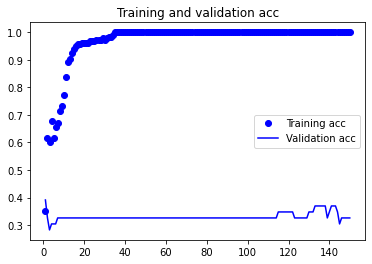

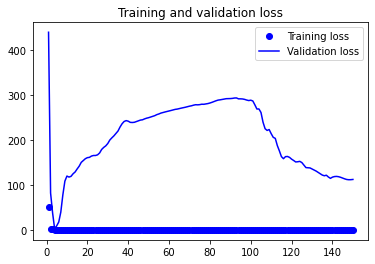

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* history를 지운 이유는 history가 남아있으면 gpu메모리를 계속 잡아두기 때문에 지움

In [15]:
del history

* conv_base의 layer 중 'conv5_block3_3_conv'가 나올 때 까지 layer.trainable = False가 되다가 
      'conv5_block3_3_conv'를 만나면 set_trainable = True로 바뀌면서 그 후 나오는 layer들이 True가 된다.

In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
print(len(model2.trainable_weights))

8


In [18]:
model2.save('den_trans')

* 컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 변경 사항 적용

In [19]:
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history2 = model2.fit(train_data2, one_hot_train_labels,
                    epochs=150,
                    batch_size=40, 
                    validation_data=(val_data2, one_hot_validation_labels))

Train on 183 samples, validate on 46 samples
Epoch 1/150
183/183 [==============================] - 4s 23ms/step - loss: 7.9183e-05 - acc: 1.0000 - val_loss: 4.2742 - val_acc: 0.3478
Epoch 2/150
183/183 [==============================] - 3s 14ms/step - loss: 5.9197e-05 - acc: 1.0000 - val_loss: 2.3089 - val_acc: 0.3261
Epoch 3/150
183/183 [==============================] - 3s 14ms/step - loss: 6.0541e-05 - acc: 1.0000 - val_loss: 2.0046 - val_acc: 0.3478
Epoch 4/150
183/183 [==============================] - 3s 14ms/step - loss: 5.2529e-05 - acc: 1.0000 - val_loss: 2.2335 - val_acc: 0.3696
Epoch 5/150
183/183 [==============================] - 3s 14ms/step - loss: 4.9526e-05 - acc: 1.0000 - val_loss: 2.6014 - val_acc: 0.3913
Epoch 6/150
183/183 [==============================] - 3s 14ms/step - loss: 4.3341e-05 - acc: 1.0000 - val_loss: 2.8173 - val_acc: 0.3696
Epoch 7/150
183/183 [==============================] - 3s 14ms/step - loss: 4.3687e-05 - acc: 1.0000 - val_loss: 2.9155 - val_a

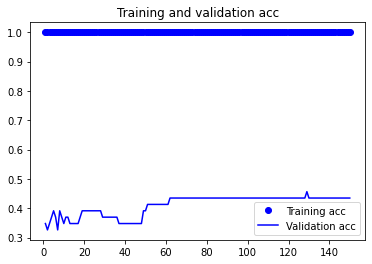

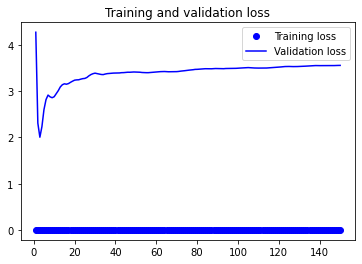

In [21]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
del history2